# Sentence Embedding Time Series Generation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import tikzplotlib
import random
import ast
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from gensim.utils import tokenize
from gensim.models import Doc2Vec
from nltk.corpus import stopwords

2023-02-12 23:48:44.827941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-02-12 23:48:46.475449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-12 23:48:46.475569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-12 23:48:46.475582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [4]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,14308,"[""Make yaself, Don't break yaself"", ""Make yase...",pop,14308,"['Make Problems, Then Let Them', 'Make peace, ...","[""We've been living in a fantasy"", ""I said we'..."
1,36771,"['You will always be my baby', ""There's a thou...",pop,36771,"['You shall long be my baby', ""There's a thous...","['I still see your coat hangin on the door', '..."
2,33221,"['Hard to find a way to get through', ""It's a ...",pop,33221,"['Hard times find another way to cut through',...","['relaxin maxin to the maximum', 'to tracks a ..."
3,31036,"[""We're boarding the night train"", ""We're bore...",pop,31036,"[""We're behind the first train"", ""We're bored ...","[""Early mornin' wake up"", 'Gently with the Car..."
4,10925,"['Come come baby', 'I can see you wanna touch ...",pop,10925,"['Come come come', 'I wanna see people wanna t...",['I hear the click-clack of your feet on the s...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           150 non-null    int64 
 1   lyrics          150 non-null    object
 2   genre           150 non-null    object
 3   id              150 non-null    int64 
 4   similar_lyrics  150 non-null    object
 5   random_lyrics   150 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.2+ KB


In [6]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))
df['similar_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['similar_lyrics']))
df['random_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['random_lyrics']))

In [7]:
random.choice(df['lyrics'])

['Written by Jay Kay and Toby Smith',
 'If I pick it up I can put it down,',
 "Whatever it is I just can't stop,",
 "For only 20 seconds at a time it's all mine.",
 'I got, too much, pressure,',
 "Got me under it's thumb",
 "And it's no fun, you can lose",
 "Now I got a choice but I can't choose",
 "Insistent as you are, is no guarantee that you'll go far",
 'Rock steady if you can',
 "But I've never been a steady man,",
 'People, wanna shoot you down,',
 "If you can't swim then you will drown",
 "In sorrow, can't get any medical attention till tomorow,",
 'Sadlands, are where I live,',
 "But that's none of your business,",
 'You keep asking, and soon enough',
 'The kids gonna have to get rough,',
 "Maybe I'm a speed king",
 "Push with the foot and I'm smiling,",
 'I can glide on the love inside,',
 'And there was you thinking that my hands were tied',
 'All along I saw you hoping',
 "I would slip and I'm not joking",
 'The evidence in these events',
 'Is still your lack of commonsense

In [8]:
toy_lyrics = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
toy_lyrics.head()

,lyrics,part
0,"Yo, listen up, I got a story to tell",intro
1,"Gonna take you on a journey, can you feel?",intro
2,"I was born in the ghetto, raised in the streets",verse
3,"Never had much, but I made it with heat",verse
4,"I fought for my dreams, never gave up the fight",verse


In [9]:
eg_lyrics = list(toy_lyrics['lyrics'])
eg_lyrics

['Yo, listen up, I got a story to tell',
 'Gonna take you on a journey, can you feel?',
 'I was born in the ghetto, raised in the streets',
 'Never had much, but I made it with heat',
 'I fought for my dreams, never gave up the fight',
 "Now I'm living my best life, shining bright",
 "Yeah, yeah, I'm the one, hear my voice",
 'got the fire, gonna make some noise',
 "I'm the master of the game, that's a fact",
 'got the skills, never looking back',
 "I've been through the ups and the downs, the twists and the turns",
 'But I always keep my head up, never letting my fire burn',
 "I've got the power, got the drive, never gonna stop",
 'Gonna make my mark, till the beat drops',
 "Yeah, yeah, I'm the one, hear my voice",
 'got the fire, gonna make some noise',
 "I'm the master of the game, that's a fact",
 'got the skills, never looking back',
 'So listen up, hear what I say',
 "I'm the king of the game, leading the way",
 "With my rhymes, and my flows, I'm unstoppable",
 "Gonna take the wo

## Sentence BERT

In [10]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generate a multivariate time series for text as a sequence of sentence embedding (SBERT)
generate_multi_ts = lambda lyrics, model: np.array([model.encode(verse) for verse in lyrics])

In [11]:
eg_multi_ts = generate_multi_ts(eg_lyrics, model)
eg_multi_ts.shape

(22, 384)

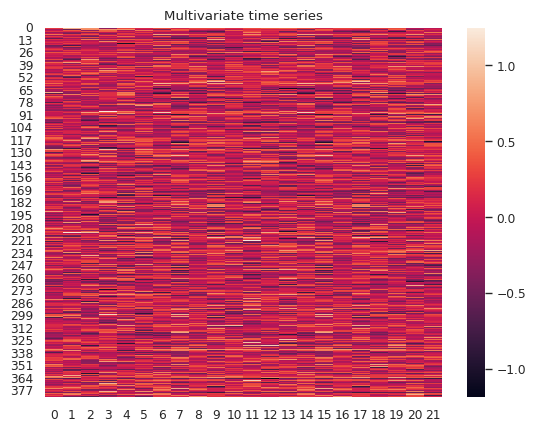

In [12]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_title('Multivariate time series')
tikzplotlib.save('../tikz/sbert_multi_ts.tex')

In [13]:
parts_of_lyrics = list(toy_lyrics['part'])
color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(parts_of_lyrics))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

In [14]:
eg_uni_ts = np.mean(eg_multi_ts, axis=1)

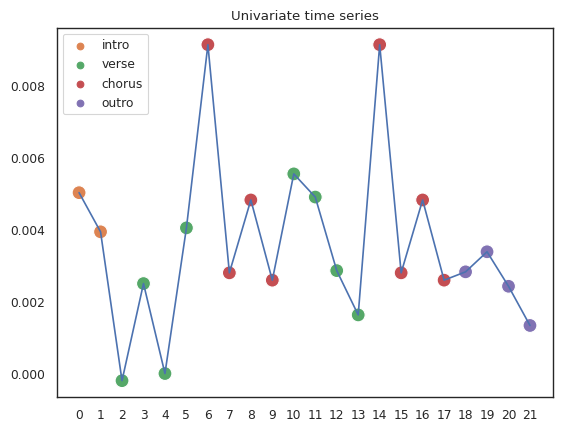

In [15]:
fig, ax = plt.subplots()
ax = plt.plot(eg_uni_ts)
# Draw dots representing parts of the lyrics
ax =  sns.scatterplot(y = eg_uni_ts,
                      x = range(len(eg_uni_ts)),
                      hue=parts_of_lyrics, s=100,
                      palette=color_map)

ax.set_title('Univariate time series')
ax.set_xticks(range(len(eg_uni_ts)))

plt.legend(loc='upper left')
tikzplotlib.save('../tikz/sbert_uni_ts_avg.tex')


In [16]:
eg_uni_ts = np.max(eg_multi_ts, axis=1)

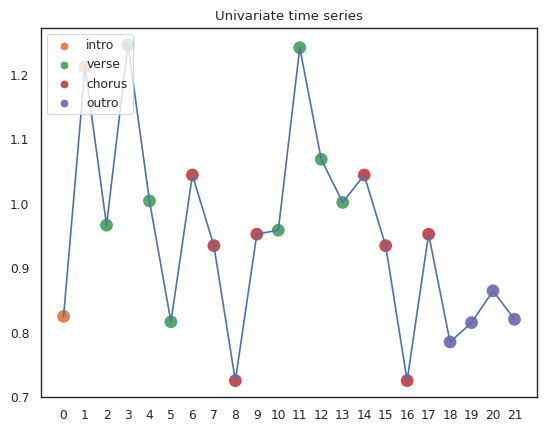

In [17]:
fig, ax = plt.subplots()
ax = plt.plot(eg_uni_ts)
# Draw dots representing parts of the lyrics
ax =  sns.scatterplot(y = eg_uni_ts,
                      x = range(len(eg_uni_ts)),
                      hue=parts_of_lyrics, s=100,
                      palette=color_map)

ax.set_title('Univariate time series')
ax.set_xticks(range(len(eg_uni_ts)))

plt.legend(loc='upper left')
tikzplotlib.save('../tikz/sbert_uni_ts_max.tex')


In [18]:
pca = PCA(n_components=1, random_state=42)

pca_output = pca.fit_transform(eg_multi_ts)

eg_uni_ts = np.array(list(
    map(lambda unique_element: unique_element[0], pca_output)))

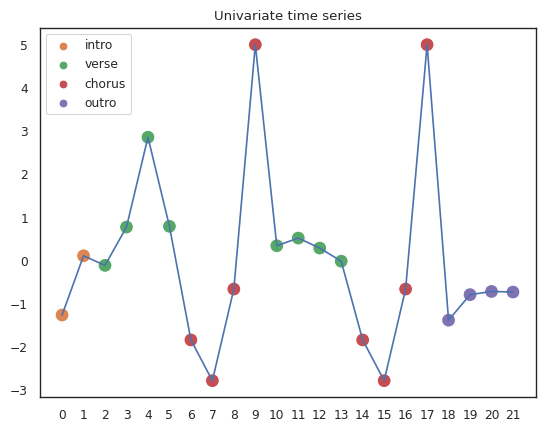

In [19]:
fig, ax = plt.subplots()
ax = plt.plot(eg_uni_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_uni_ts,
                     x = range(len(eg_uni_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)

ax.set_title('Univariate time series')
ax.set_xticks(range(len(eg_uni_ts)))

plt.legend(loc='upper left')
tikzplotlib.save('../tikz/sbert_uni_ts_pca.tex')

In [20]:
global_pca = joblib.load('../models/sbert_pca.pkl')

In [21]:
pca_output = global_pca.transform(eg_multi_ts)

eg_uni_ts = np.array(list(
    map(lambda unique_element: unique_element[0], pca_output)))

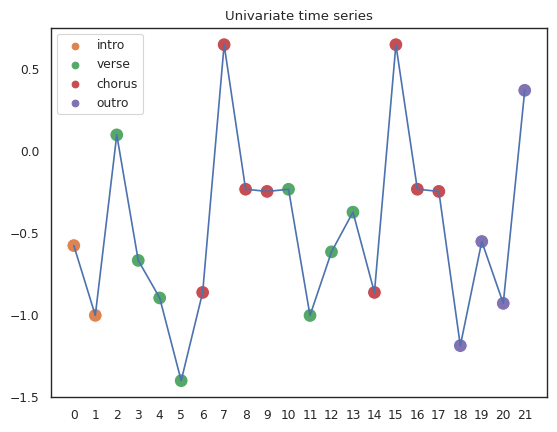

In [22]:
fig, ax = plt.subplots()
ax = plt.plot(eg_uni_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_uni_ts,
                     x = range(len(eg_uni_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)

ax.set_title('Univariate time series')
ax.set_xticks(range(len(eg_uni_ts)))

plt.legend(loc='upper left')
tikzplotlib.save('../tikz/sbert_uni_ts_gpca.tex')

In [23]:
def generate_uni_ts(multi_ts, normalize=False, pooling_method='avg', scaler=None, pca=None):
    """
    Convert a multi-variate time series represented as a numpy array into a uni-variate time series.
    
    Parameters
    ----------
    multi_ts : numpy array
        A 2D array representing the multi-variate time series with shape (n_samples, n_features)
    normalize: bool, optional
        Whether to normalize the input data using standard scaler. Default is False.
    pooling_method : str, optional
        The method to use for pooling the multi-variate time series into a uni-variate time series.
        Must be one of 'avg', 'max', or 'pca'. Default is 'avg'.
    scaler: object, optional
        Scaler object to use to normalize the data. Default is None.
    pca: object, optional
        PCA object to use to reduce the data. Default is None.
        
    Returns
    -------
    uni_ts : numpy array
        A 1D array representing the uni-variate time series with shape (n_samples,)
        
    Raises
    ------
    ValueError
        If an invalid value is passed for the pooling_method
    """
    if normalize:
        if scaler is None:
            scaler = StandardScaler()
            multi_ts = scaler.fit_transform(multi_ts)
        else:
            multi_ts = scaler.transform(multi_ts)
    if pooling_method=='avg':            
        uni_ts = np.mean(multi_ts, axis=1)            
    elif pooling_method=='max':            
        uni_ts = np.max(multi_ts, axis=1)            
    elif pooling_method=='pca':                
        if pca is None:            
            pca = PCA(n_components=1, random_state=42)
            pca_output = pca.fit_transform(multi_ts)
        else: 
            pca_output = pca.transform(multi_ts)       
        uni_ts = np.array(list(
            map(lambda unique_element: unique_element[0] , pca_output)))                                     
    else:
        raise ValueError("Invalid pooling_method passed. Please use either 'avg', 'max' or 'pca'.")        
    return uni_ts

In [24]:
methods = [{'pooling_method': 'avg', 'normalize': False, 'scaler': None, 'pca': None, 'filename': 'avg'},
           {'pooling_method': 'max', 'normalize': False, 'scaler': None, 'pca': None, 'filename': 'max'},
           {'pooling_method': 'pca', 'normalize': False, 'scaler': None, 'pca': None, 'filename': 'pca'},
           {'pooling_method': 'pca', 'normalize': False, 'scaler': None, 'pca': global_pca, 'filename': 'gpca'},
           ]

for method in methods:        
    ts_data = {}
    for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:        
        ts_data[lyrics_type] = []
        for lyr in df[lyrics_type]:
            multi_ts = generate_multi_ts(lyr, model)
            uni_ts = generate_uni_ts(multi_ts, 
                                     normalize=method['normalize'], 
                                     pooling_method=method['pooling_method'],
                                     scaler=method['scaler'],
                                     pca=method['pca'])
            uni_ts = list(uni_ts)
            ts_data[lyrics_type].append(uni_ts)
    ts_data = pd.DataFrame(ts_data)

    filename = f'../data/evaluation/time-series/sbert_{method["filename"]}_ts.csv'
    ts_data.to_csv(filename, index=False)    

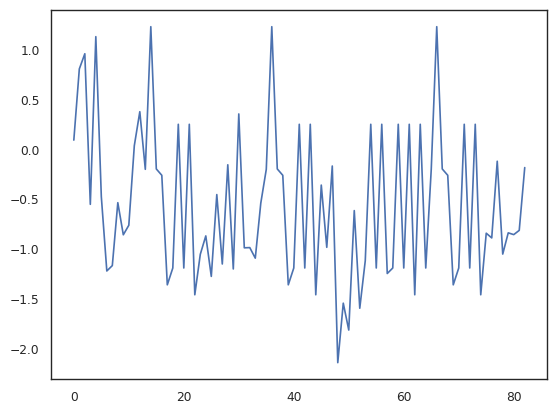

In [25]:
plt.plot(random.choice(ts_data['lyrics']))

## Doc2Vec

In [26]:
def tokenize_lyrics(lyrics, remove_stop_words=True):
    tokenized_lyrics = []
    for verse in lyrics:
        tokens = list(tokenize(verse, lowercase=True))
        if remove_stop_words:
            stop_words = stopwords.words('english')
            tokens = [token for token in tokens if token not in stop_words]
        tokenized_lyrics.append(tokens)
    return tokenized_lyrics

In [27]:
tokenize_lyrics(eg_lyrics)

[['yo', 'listen', 'got', 'story', 'tell'],
 ['gonna', 'take', 'journey', 'feel'],
 ['born', 'ghetto', 'raised', 'streets'],
 ['never', 'much', 'made', 'heat'],
 ['fought', 'dreams', 'never', 'gave', 'fight'],
 ['living', 'best', 'life', 'shining', 'bright'],
 ['yeah', 'yeah', 'one', 'hear', 'voice'],
 ['got', 'fire', 'gonna', 'make', 'noise'],
 ['master', 'game', 'fact'],
 ['got', 'skills', 'never', 'looking', 'back'],
 ['ups', 'downs', 'twists', 'turns'],
 ['always', 'keep', 'head', 'never', 'letting', 'fire', 'burn'],
 ['got', 'power', 'got', 'drive', 'never', 'gonna', 'stop'],
 ['gonna', 'make', 'mark', 'till', 'beat', 'drops'],
 ['yeah', 'yeah', 'one', 'hear', 'voice'],
 ['got', 'fire', 'gonna', 'make', 'noise'],
 ['master', 'game', 'fact'],
 ['got', 'skills', 'never', 'looking', 'back'],
 ['listen', 'hear', 'say'],
 ['king', 'game', 'leading', 'way'],
 ['rhymes', 'flows', 'unstoppable'],
 ['gonna', 'take', 'world', 'storm', 'unstoppable']]

In [28]:
model = Doc2Vec.load("../models/doc2vec.model")

In [29]:
# Generate a multivariate time series for text as a sequence of sentence embedding (Doc2Vec)
generate_multi_ts = lambda lyrics, model: np.array([model.infer_vector(verse) for verse in lyrics])

In [30]:
eg_tokenized_lyrics = tokenize_lyrics(eg_lyrics)

eg_multi_ts = generate_multi_ts(eg_tokenized_lyrics, model)
eg_multi_ts.shape

(22, 50)

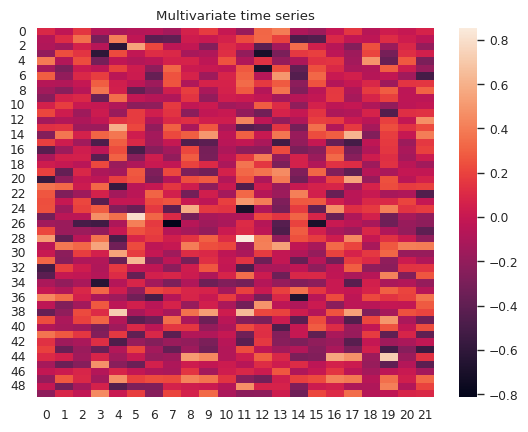

In [31]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_title('Multivariate time series')
tikzplotlib.save('../tikz/d2v_multi_ts.tex')

In [32]:
global_scaler = joblib.load('../models/d2v_scaler.pkl')
global_pca = joblib.load('../models/d2v_pca.pkl')

In [33]:
methods = [{'pooling_method': 'avg', 'normalize': True, 'scaler': None, 'pca': None, 'filename': 'avg'},
           {'pooling_method': 'max', 'normalize': True, 'scaler': None, 'pca': None, 'filename': 'max'},
           {'pooling_method': 'pca', 'normalize': True, 'scaler': None, 'pca': None, 'filename': 'pca'},
           {'pooling_method': 'pca', 'normalize': True, 'scaler': global_scaler, 'pca': global_pca, 'filename': 'gpca'},
           ]

for method in methods:          
    ts_data = {}
    for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:        
        ts_data[lyrics_type] = []
        for lyr in df[lyrics_type]:
            tokenized_lyr = tokenize_lyrics(lyr)
            multi_ts = generate_multi_ts(tokenized_lyr, model)
            uni_ts = generate_uni_ts(multi_ts, 
                                     normalize=method['normalize'], 
                                     pooling_method=method['pooling_method'],
                                     scaler=method['scaler'],
                                     pca=method['pca'])
            uni_ts = list(uni_ts)
            ts_data[lyrics_type].append(uni_ts)
    ts_data = pd.DataFrame(ts_data)

    filename = f'../data/evaluation/time-series/d2v_{method["filename"]}_ts.csv'
    ts_data.to_csv(filename, index=False)    

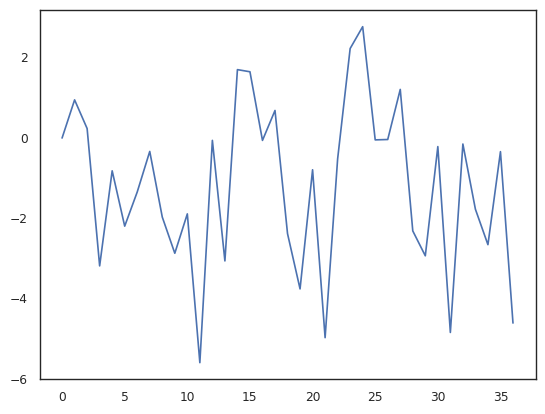

In [34]:
plt.plot(random.choice(ts_data['lyrics']))